**Prepare the data:** create random samples of 200 documents of each book, representative of the source input. Prepare the records of 100 words records for each document, label them as a, b and c etc. as per the book they belong to.

**Preprocess the data:** remove stop-words and garbage characters if needed.

**Transform** to BOW, and TF-IDF, n-gram, (LDA, word-embedding, optional) etc.

**Train** a machine that can tell which author (or genre), when asked!

**Evaluation:** Do ten-fold cross-validation.

**Perform Error-Analysis:** Identity what were the characteristics of the instance records that threw the machine off.

Document your steps, explain the results effectively, using graphs.

Verify and validate your programs; Make sure your programs run without syntax or logical errors.

**Massage the data:** Reduce the number of words per document if the accuracy is too high and then repeat the above steps.

## Table of Contents


1. Environment Setup
2. Data Preparation
3. Data Transformations
-  Bag-of-Words using CountVectorizer()
-  Term Frequency–Inverse Document Frequency (TF-IDF) 
-  Word2Vec
-  LDA
4. Machine Learning Model Experimentation
-  Fitting models with only BOW
-  Fitting models with BOW + TF-IDF
-  Fitting models without removing StopWords and Punctuation
-  Fitting models with lesser number of words
5. Model Evaluation


## 1. Environment Setup

In [44]:
# Data manipulation libraries
import numpy as np
import pandas as pd
import string
import textwrap
import re
import gensim 
import spacy
import gensim.models
import logging  # Setting up the loggings to monitor gensim
import multiprocessing


# Natural Language Processing libraries
import nltk
nltk.download('gutenberg')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import gutenberg as gut
from nltk.corpus import stopwords
from nltk.collocations import *
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.tokenize import sent_tokenize, word_tokenize 
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
from gensim.models.phrases import Phrases, Phraser

# Data Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Scikit-learn Packages
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from gensim.models import Word2Vec
from spacy import displacy

# Import Machine Learning Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\shobh\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shobh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shobh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 2. Data Preparation

In [45]:
# Function to remove punctuations and stopwords
def text_process_clean(mess):
    remove_punc = [char for char in mess if char not in string.punctuation]
    remove_punc = ''.join(remove_punc)
    word=[word+' ' for word in remove_punc.split() if word.lower() not in stopwords.words('english')]
    return re.sub(r"\b\d+\b","",("".join(word)))

# Function to remove punctuations and stopwords
def text_process(mess):
    remove_punc = [char for char in mess if char not in string.punctuation]
    remove_punc = ''.join(remove_punc)
    #word=[word+' ' for word in remove_punc.split() if word.lower() not in stopwords.words('english')]
    return [word for word in remove_punc.split() if word.lower() not in stopwords.words('english')]

In [46]:
# Dataset according to the requirements of the assignment

tokenizer = RegexpTokenizer('\s+', gaps=True)
Book_dict={"A":"austen-emma.txt", "B":"bible-kjv.txt", "C":"carroll-alice.txt",
           "D":"chesterton-thursday.txt", "E":"shakespeare-caesar.txt"}
Sampling=[]
Records=[]
for index_count in Book_dict:
    doc = ""
    labeled_docs=[]
    count,j=0,0
    text=nltk.corpus.gutenberg.raw(Book_dict[index_count])
    tokenized_word=tokenizer.tokenize(text)
    for i, word in enumerate(tokenized_word):
        if(j<101):
            if(re.search('\w',word) and word!=''):
                doc=doc+' '+word
            else:
                doc=doc+word
            j+=1
        else:
            count+=1
            j=0
            labeled_docs.append(doc)
            doc=word
    ser=pd.Series(labeled_docs)
    for i in ser.sample(200).values:
        Sampling.append(i)
        Records.append(index_count)
df = pd.DataFrame(list(zip(Sampling,Records)), columns=["Data", "Target"])
df["Cleaned"] = df["Data"].apply(text_process_clean)
df["Words"]   = df["Data"].apply(text_process)


# Dataset with reduced number of words

for index_count in Book_dict:
    doc = ""
    labeled_docs=[]
    count,j=0,0
    text=nltk.corpus.gutenberg.raw(Book_dict[index_count])
    tokenized_word=tokenizer.tokenize(text)
    for i, word in enumerate(tokenized_word):
        if(j<20):
            if(re.search('\w',word) and word!=''):
                doc=doc+' '+word
            else:
                doc=doc+word
            j+=1
        else:
            count+=1
            j=0
            labeled_docs.append(doc)
            doc=word
    ser=pd.Series(labeled_docs)
    for i in ser.sample(200).values:
        Sampling.append(i)
        Records.append(index_count)
df_new = pd.DataFrame(list(zip(Sampling,Records)), columns=["Data", "Target"])

In [60]:
df["Cleaned"][0]

'done love like man soon discomposed hot morning Harriets sweet easy temper mind gone long enough comfortable meal came back bettergrown quite cooland good manners like himselfable draw chair close take interest employment regret reasonable way late best spirits seemed trying improve last made talk nonsense '

## 3. Data Transformations
### 3.1 Bag-of-Words Using CountVectorizer()

In [4]:
bow_fit = CountVectorizer(analyzer=text_process).fit(df['Data'])
bow_transform = bow_fit.transform(df['Data'])
print('Vocabulary Length: ', len(bow_fit.vocabulary_))
print(bow_transform)
print('Shape of Sparse Matrix: ', bow_transform.shape)
print('Amount of Non-Zero occurences: ', bow_transform.nnz)

Vocabulary Length:  11295
  (0, 2109)	2
  (0, 2981)	2
  (0, 3829)	1
  (0, 4419)	1
  (0, 4456)	1
  (0, 4560)	1
  (0, 4575)	1
  (0, 4581)	1
  (0, 5404)	1
  (0, 5410)	2
  (0, 5432)	1
  (0, 5510)	1
  (0, 5599)	1
  (0, 6239)	1
  (0, 6352)	1
  (0, 7062)	1
  (0, 7305)	1
  (0, 7417)	1
  (0, 7544)	1
  (0, 7572)	1
  (0, 7612)	1
  (0, 7620)	1
  (0, 7685)	1
  (0, 7706)	1
  (0, 7770)	1
  :	:
  (999, 2848)	1
  (999, 2867)	1
  (999, 2947)	1
  (999, 3008)	1
  (999, 3041)	1
  (999, 3487)	1
  (999, 3762)	1
  (999, 4174)	1
  (999, 4793)	1
  (999, 5174)	1
  (999, 5802)	1
  (999, 6120)	1
  (999, 6548)	2
  (999, 6652)	1
  (999, 7054)	1
  (999, 7073)	1
  (999, 7981)	1
  (999, 7986)	1
  (999, 8924)	1
  (999, 9481)	1
  (999, 9516)	1
  (999, 10314)	2
  (999, 10364)	3
  (999, 10905)	1
  (999, 11138)	1
Shape of Sparse Matrix:  (1000, 11295)
Amount of Non-Zero occurences:  43772


### 3.2 Term Frequency–Inverse Document Frequency (TF-IDF)

In [5]:
tfidf_transform = TfidfTransformer().fit(bow_transform)
tfidf = tfidf_transform.transform(bow_transform)
print(tfidf)

  (0, 11136)	0.13409384805278682
  (0, 10289)	0.08877109573470515
  (0, 10036)	0.16667275448514104
  (0, 10009)	0.13907899091689244
  (0, 9502)	0.13647790975418064
  (0, 9157)	0.16496966946224442
  (0, 9103)	0.05751604883910416
  (0, 8837)	0.1704907076661909
  (0, 8298)	0.15507962444373388
  (0, 8146)	0.20630992790092367
  (0, 7928)	0.14382592484206846
  (0, 7770)	0.09944181750110981
  (0, 7706)	0.08877109573470515
  (0, 7685)	0.08900642362084686
  (0, 7620)	0.16330508111021802
  (0, 7612)	0.1704907076661909
  (0, 7572)	0.1748982111516252
  (0, 7544)	0.12985019703159106
  (0, 7417)	0.10548360445842873
  (0, 7305)	0.10590720000992541
  (0, 7062)	0.1575674691148309
  (0, 6352)	0.12794334546349748
  (0, 6239)	0.1748982111516252
  (0, 5599)	0.20630992790092367
  (0, 5510)	0.09811170899115698
  :	:
  (999, 2563)	0.1349350165934522
  (999, 2514)	0.14296883397183752
  (999, 2463)	0.14296883397183752
  (999, 2349)	0.14296883397183752
  (999, 2343)	0.14296883397183752
  (999, 2342)	0.1429688339

### 3.3 Word2Vec

In [6]:
# *** Include Word2Vec Code and Visualization ***

### 3.4 LDA

In [7]:


from nltk.tokenize import RegexpTokenizer
df_req = df["Cleaned"]
# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(df_req)):
    df_req[idx] = df_req[idx].lower()  # Convert to lowercase.
    df_req[idx] = tokenizer.tokenize(df_req[idx])  # Split into words.

    
# Remove numbers, but not words that contain numbers.
df_req = [[token for token in doc if not token.isnumeric()] for doc in df_req]

# Remove words that are only one character.
df_req = [[token for token in doc if len(token) > 1] for doc in df_req]

from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
df_req = [[lemmatizer.lemmatize(token) for token in doc] for doc in df_req]

# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(df_req, min_count=20)
for idx in range(len(df_req)):
    for token in bigram[df_req[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            df_req[idx].append(token)
            
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(df_req)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)


# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in df_req]


print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)


top_topics = model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

Number of unique tokens: 405
Number of documents: 1000
Average topic coherence: -2.6737.
[([(0.0473955, 'caesar'),
   (0.03383788, 'brutus'),
   (0.032096103, 'bru'),
   (0.030637624, 'haue'),
   (0.023675675, 'shall'),
   (0.022468634, 'cassi'),
   (0.01844255, 'come'),
   (0.017864557, 'cassius'),
   (0.015974773, 'antony'),
   (0.014630223, 'let'),
   (0.014218344, 'men'),
   (0.01387452, 'good'),
   (0.013657521, 'enter'),
   (0.013519571, 'know'),
   (0.013094191, 'thou'),
   (0.012824464, 'v'),
   (0.011676773, 'heere'),
   (0.011060715, 'man'),
   (0.010218449, 'ant'),
   (0.009960085, 'well')],
  -1.5903240397448868),
 ([(0.062068317, 'mr'),
   (0.025100755, 'would'),
   (0.02295857, 'emma'),
   (0.020269489, 'miss'),
   (0.0187602, 'could'),
   (0.01739807, 'must'),
   (0.016288104, 'weston'),
   (0.015589143, 'mr_weston'),
   (0.014671926, 'one'),
   (0.014135759, 'much'),
   (0.013277915, 'said'),
   (0.012156235, 'say'),
   (0.011691427, 'thing'),
   (0.011431327, 'know'),


## 4. Machine Learning Model Experimentation
### 4.1 Fitting models with only Bag-of-Words

In [8]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(df['Data'], df['Target'], test_size=0.2, random_state=42)

In [9]:
models = {"RandomForestClassifier" : RandomForestClassifier(),
          "SupportVectorMachines" : SVC(),
          "KNearestNeighbor" : KNeighborsClassifier()
          }

def fit_and_score_bow(models, X_train, y_train, X_test, y_test):
    '''
    Fits and evaluates the machine learning models with only BOW in pipeline.
    models : a dict of different Scikit-Learn machine learning models.
    X_train : training data (no labels)
    y_train : training lables
    X_test : testing data (no labels)
    y_test : testing lables
    Returns Model Scores and Predictions as Dictionary
    '''
    model_scores = {}
    predictions = {}
    for name, model in models.items():
      pipeline_bow = Pipeline([('bow', CountVectorizer(analyzer=text_process)), # Bag of Words
                               ('model', model)])                               # Fit the model
      pipeline_bow.fit(X_train, y_train)
      predictions[name] = pipeline_bow.predict(X_test) 
      model_scores[name] = cross_val_score(pipeline_bow, X_test, y_test, cv=10, scoring="accuracy") # 10-Fold Cross-Validation
    return model_scores, predictions

# Storing the scores and predictions
model_scores_bow, predictions_bow = fit_and_score_bow(models=models,
                             X_train=X_train,
                             y_train=y_train,
                             X_test=X_test,
                             y_test=y_test)

# Taking the average of the K-Fold Cross-Validated Scores
model_scores_bow_avg = {}
for name, model in model_scores_bow.items():
  model_scores_bow_avg[name] = np.mean(model)

# Converting it into a dataframe
model_scores_bow_avg_df = pd.DataFrame(model_scores_bow_avg, index=["Accuracy"]).T
model_scores_bow_avg_df 

,Accuracy
RandomForestClassifier,0.935
SupportVectorMachines,0.825
KNearestNeighbor,0.560


### 4.2 Fitting models with Bag-of-Words and TF-IDF

In [10]:
def fit_and_score_bow_tdif(models, X_train, y_train, X_test, y_test):
    '''
    Fits and evaluates the machine learning models with BOW and TF-IDF in pipeline.
    models : a dict of different Scikit-Learn machine learning models.
    X_train : training data (no labels)
    y_train : training lables
    X_test : testing data (no labels)
    y_test : testing lables
    Returns Model Scores and Predictions as Dictionary
    '''
    model_scores = {}
    predictions = {}
    for name, model in models.items():
      pipeline_bow_tdif = Pipeline([('bow', CountVectorizer(analyzer=text_process)), # Bag of Words
                                    ('tfidf', TfidfTransformer()), # TF-IDF
                                    ('model', model)]) # Fit the model
      pipeline_bow_tdif.fit(X_train, y_train)
      predictions[name] = pipeline_bow_tdif.predict(X_test) 
      model_scores[name] = cross_val_score(pipeline_bow_tdif, X_test, y_test, cv=10, scoring="accuracy") # 10-Fold Cross-Validation
    return model_scores, predictions

# Storing the scores and predictions
model_scores_bow_tdif, predictions_bow_tdif = fit_and_score_bow_tdif(models=models,
                             X_train=X_train,
                             y_train=y_train,
                             X_test=X_test,
                             y_test=y_test)

# Taking the average of the K-Fold Cross-Validated Scores
model_scores_bow_tdif_avg = {}
for name, model in model_scores_bow_tdif.items():
  model_scores_bow_tdif_avg[name] = np.mean(model)

# Converting it into a dataframe
model_scores_bow_tdif_avg_df = pd.DataFrame(model_scores_bow_tdif_avg, index=["Accuracy"]).T
model_scores_bow_tdif_avg_df

,Accuracy
RandomForestClassifier,0.915
SupportVectorMachines,0.960
KNearestNeighbor,0.940


### 4.3 Fitting models without removing StopWords and Punctuations

In [11]:
def fit_and_score_no(models, X_train, y_train, X_test, y_test):
    '''
    Fits and evaluates the machine learning models without removing stopwords and punctuations.
    models : a dict of different Scikit-Learn machine learning models.
    X_train : training data (no labels)
    y_train : training lables
    X_test : testing data (no labels)
    y_test : testing lables
    Returns Model Scores and Predictions as Dictionary
    '''
    model_scores = {}
    predictions = {}
    for name, model in models.items():
      pipeline_bow_no = Pipeline([('bow', CountVectorizer()), # Bag of Words
                                    ('model', model)]) # Fit the model
      pipeline_bow_no.fit(X_train, y_train)
      predictions[name] = pipeline_bow_no.predict(X_test) 
      model_scores[name] = cross_val_score(pipeline_bow_no, X_test, y_test, cv=10, scoring="accuracy") # 10-Fold Cross-Validation
    return model_scores, predictions

# Storing the scores and predictions
model_scores_no, predictions_no = fit_and_score_no(models=models,
                             X_train=X_train,
                             y_train=y_train,
                             X_test=X_test,
                             y_test=y_test)

# Taking the average of the K-Fold Cross-Validated Scores
model_scores_no_avg = {}
for name, model in model_scores_no.items():
  model_scores_no_avg[name] = np.mean(model)

# Converting it into a dataframe
model_scores_no_avg_df = pd.DataFrame(model_scores_no_avg, index=["Accuracy"]).T
model_scores_no_avg_df

,Accuracy
RandomForestClassifier,0.925
SupportVectorMachines,0.915
KNearestNeighbor,0.760


### 4.4 Fitting models with a dataset containing lesser number of words

In [12]:
# Splitting the data into train and test
X_train_, X_test_, y_train_, y_test_ = train_test_split(df_new["Data"], df_new["Target"], test_size=0.2)

def fit_and_score_less(models, X_train, y_train, X_test, y_test):
    '''
    Fits and evaluates the machine learning models with lesser words.
    models : a dict of different Scikit-Learn machine learning models.
    X_train : training data (no labels)
    y_train : training lables
    X_test : testing data (no labels)
    y_test : testing lables
    Returns Model Scores and Predictions as Dictionary
    '''
    model_scores = {}
    predictions = {}
    for name, model in models.items():
      pipeline_bow_less = Pipeline([('bow', CountVectorizer(analyzer=text_process)), # Bag of Words
                                    ('model', model)]) # Fit the model
      pipeline_bow_less.fit(X_train, y_train)
      predictions[name] = pipeline_bow_less.predict(X_test) 
      model_scores[name] = cross_val_score(pipeline_bow_less, X_test, y_test, cv=10, scoring="accuracy") # 10-Fold Cross-Validation
    return model_scores, predictions

# Storing the scores and predictions
model_scores_less, predictions_less = fit_and_score_less(models=models,
                             X_train=X_train_,
                             y_train=y_train_,
                             X_test=X_test_,
                             y_test=y_test_)

# Taking the average of the K-Fold Cross-Validated Scores
model_scores_less_avg = {}
for name, model in model_scores_less.items():
  model_scores_less_avg[name] = np.mean(model)

# Converting it into a dataframe
model_scores_less_avg_df = pd.DataFrame(model_scores_less_avg, index=["Accuracy"]).T
model_scores_less_avg_df

,Accuracy
RandomForestClassifier,0.7175
SupportVectorMachines,0.6200
KNearestNeighbor,0.4725


## 5. Model Evaluations

### 5.1 Models fitted with only BOW

Text(0.5, 1.0, 'Model Accuracy with only BOW')

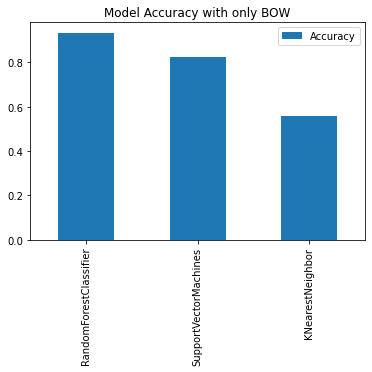

In [13]:
# Bar Graph of Accuracies
fig1 = model_scores_bow_avg_df.plot(kind='bar')
fig1.set_title("Model Accuracy with only BOW")

Classifications Reports

In [14]:
# Classification Report BOW RFC
print(classification_report(y_test, predictions_bow["RandomForestClassifier"]))

              precision    recall  f1-score   support

           A       1.00      0.97      0.98        33
           B       1.00      0.96      0.98        48
           C       0.95      1.00      0.97        37
           D       0.93      0.97      0.95        38
           E       1.00      0.98      0.99        44

    accuracy                           0.97       200
   macro avg       0.97      0.98      0.97       200
weighted avg       0.98      0.97      0.98       200



In [15]:
# Classification Report BOW SVC
print(classification_report(y_test, predictions_bow["SupportVectorMachines"]))

              precision    recall  f1-score   support

           A       0.87      1.00      0.93        33
           B       1.00      0.94      0.97        48
           C       1.00      0.89      0.94        37
           D       0.86      0.95      0.90        38
           E       1.00      0.95      0.98        44

    accuracy                           0.94       200
   macro avg       0.95      0.95      0.94       200
weighted avg       0.95      0.94      0.95       200



In [16]:
# Classification Report BOW KNN
print(classification_report(y_test, predictions_bow["KNearestNeighbor"]))

              precision    recall  f1-score   support

           A       0.36      0.97      0.52        33
           B       0.97      0.58      0.73        48
           C       0.81      0.92      0.86        37
           D       1.00      0.24      0.38        38
           E       1.00      0.70      0.83        44

    accuracy                           0.67       200
   macro avg       0.83      0.68      0.66       200
weighted avg       0.85      0.67      0.67       200



Confusion Matrices

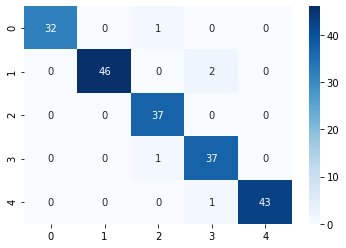

In [17]:
# Confusion Matrix RandomForestClassifier
sns.heatmap(confusion_matrix(y_test, predictions_bow["RandomForestClassifier"]), cmap= "Blues", annot=True, fmt='')

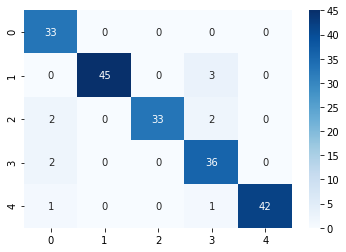

In [18]:
# Confusion Matrix SupportVectorMachines
sns.heatmap(confusion_matrix(y_test, predictions_bow["SupportVectorMachines"]), cmap= "Blues", annot=True, fmt='')

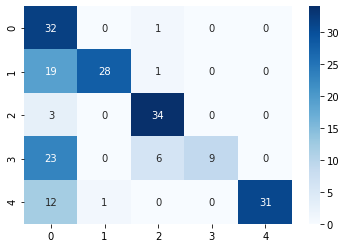

In [19]:
# Confusion Matrix KNearestNeighbor
sns.heatmap(confusion_matrix(y_test, predictions_bow["KNearestNeighbor"]), cmap= "Blues", annot=True, fmt='')

### 5.2 Models Fitted with BOW + TF-IDF

Text(0.5, 1.0, 'Model Accuracy with only BOW + TF-IDF')

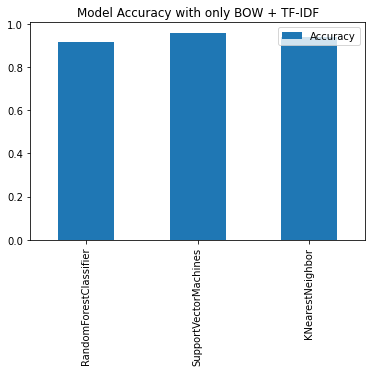

In [20]:
fig2 = model_scores_bow_tdif_avg_df.plot(kind='bar')
fig2.set_title("Model Accuracy with only BOW + TF-IDF")

Classification Reports

In [21]:
# Classification Report BOW + TFIDF RFC
print(classification_report(y_test, predictions_bow_tdif["RandomForestClassifier"]))

              precision    recall  f1-score   support

           A       0.94      0.97      0.96        33
           B       1.00      0.98      0.99        48
           C       0.95      0.97      0.96        37
           D       0.95      0.92      0.93        38
           E       1.00      1.00      1.00        44

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200



In [22]:
# Classification Report BOW +TFIDF SVM
print(classification_report(y_test, predictions_bow_tdif["SupportVectorMachines"]))

              precision    recall  f1-score   support

           A       0.97      1.00      0.99        33
           B       1.00      0.96      0.98        48
           C       1.00      0.92      0.96        37
           D       0.88      0.97      0.93        38
           E       1.00      1.00      1.00        44

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200



In [23]:
# Classification Report BOW + TFIDF KNN
print(classification_report(y_test, predictions_bow_tdif["KNearestNeighbor"]))

              precision    recall  f1-score   support

           A       0.97      1.00      0.99        33
           B       0.98      1.00      0.99        48
           C       0.95      0.97      0.96        37
           D       1.00      0.95      0.97        38
           E       1.00      0.98      0.99        44

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200



Confusion Matrices

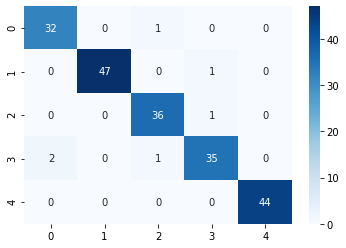

In [24]:
# Confusion Matrix BOW + TFIDF RFC
sns.heatmap(confusion_matrix(y_test, predictions_bow_tdif["RandomForestClassifier"]), cmap= "Blues", annot=True, fmt='')

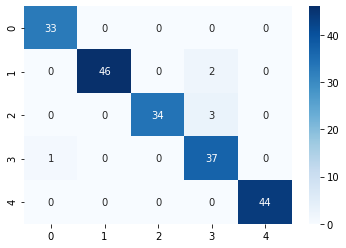

In [25]:
# Confusion Matrix SVM
sns.heatmap(confusion_matrix(y_test, predictions_bow_tdif["SupportVectorMachines"]), cmap= "Blues", annot=True, fmt='')

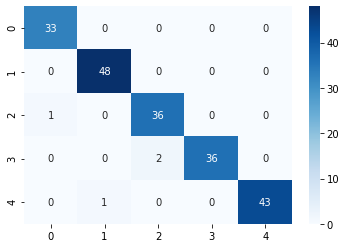

In [26]:
# Confusion Matrix KNearestNeighbor
sns.heatmap(confusion_matrix(y_test, predictions_bow_tdif["KNearestNeighbor"]), cmap= "Blues", annot=True, fmt='')

### 5.3 Models Fitted without removing StopWords and Punctuations

Text(0.5, 1.0, 'Model Accuracy without removing StopWords and Punctuations')

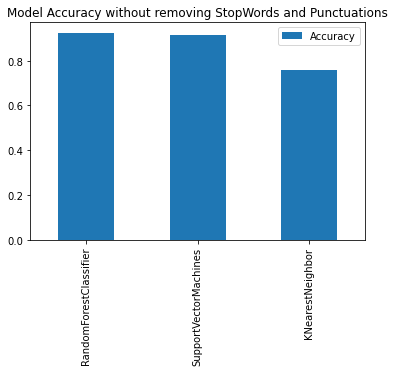

In [27]:
fig3 = model_scores_no_avg_df.plot(kind='bar')
fig3.set_title("Model Accuracy without removing StopWords and Punctuations")

Classification Reports

In [28]:
# Classification Report without removing StopWords and Punctuation RFC
print(classification_report(y_test, predictions_no["RandomForestClassifier"]))

              precision    recall  f1-score   support

           A       1.00      0.97      0.98        33
           B       1.00      1.00      1.00        48
           C       0.97      1.00      0.99        37
           D       1.00      1.00      1.00        38
           E       1.00      1.00      1.00        44

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



In [29]:
# Classification Report without removing StopWords and Punctuation SVM
print(classification_report(y_test, predictions_no["SupportVectorMachines"]))

              precision    recall  f1-score   support

           A       0.94      0.97      0.96        33
           B       0.98      0.98      0.98        48
           C       1.00      0.86      0.93        37
           D       0.88      1.00      0.94        38
           E       1.00      0.98      0.99        44

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200



In [30]:
# Classification Report without removing StopWords and Punctuation KNN
print(classification_report(y_test, predictions_no["KNearestNeighbor"]))

              precision    recall  f1-score   support

           A       0.71      0.91      0.80        33
           B       1.00      0.67      0.80        48
           C       0.94      0.92      0.93        37
           D       0.63      0.87      0.73        38
           E       0.92      0.80      0.85        44

    accuracy                           0.82       200
   macro avg       0.84      0.83      0.82       200
weighted avg       0.86      0.82      0.82       200



Confusion Matrices

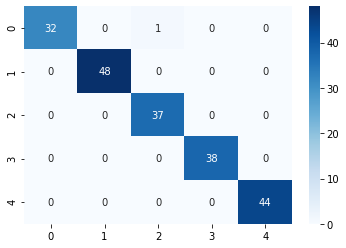

In [31]:
# Confusion Matrix without removing StopWords and Punctuation RFC
sns.heatmap(confusion_matrix(y_test, predictions_no["RandomForestClassifier"]), cmap= "Blues", annot=True, fmt='')

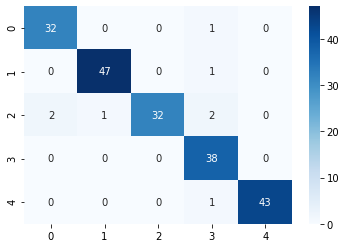

In [32]:
# Confusion Matrix without removing StopWords and Punctuation SVM
sns.heatmap(confusion_matrix(y_test, predictions_no["SupportVectorMachines"]), cmap= "Blues", annot=True, fmt='')

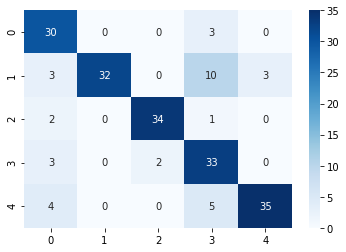

In [33]:
# Confusion Matrix without removing StopWords and Punctuation KNearestNeighbor
sns.heatmap(confusion_matrix(y_test, predictions_no["KNearestNeighbor"]), cmap= "Blues", annot=True, fmt='')

### 5.4 Models Fitted with a dataset containing lesser number of words

Text(0.5, 1.0, 'Model Accuracy with a dataset containing lesser number of words')

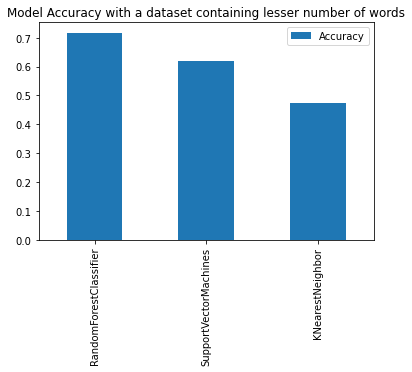

In [34]:
fig4 = model_scores_less_avg_df.plot(kind='bar')
fig4.set_title("Model Accuracy with a dataset containing lesser number of words")

Classification Reports

In [35]:
# Classification Report with a dataset containing lesser number of words RFC
print(classification_report(y_test, predictions_less["RandomForestClassifier"]))

ValueError: Found input variables with inconsistent numbers of samples: [200, 400]

In [ ]:
# Classification Report with a dataset containing lesser number of words SVM
print(classification_report(y_test, predictions_less["SupportVectorMachines"]))

In [ ]:
# Classification Report with a dataset containing lesser number of words KNN
print(classification_report(y_test, predictions_less["KNearestNeighbor"]))

Confusion Matrices

In [ ]:
# Confusion Matrix with a dataset containing lesser number of words RFC
sns.heatmap(confusion_matrix(y_test, predictions_less["RandomForestClassifier"]), cmap= "Blues", annot=True, fmt='')

In [ ]:
# Confusion Matrix with a dataset containing lesser number of words SVM
sns.heatmap(confusion_matrix(y_test, predictions_less["SupportVectorMachines"]), cmap= "Blues", annot=True, fmt='')

In [ ]:
# Confusion Matrix with a dataset containing lesser number of words KNearestNeighbor
sns.heatmap(confusion_matrix(y_test, predictions_less["KNearestNeighbor"]), cmap= "Blues", annot=True, fmt='')

Unified comparision

In [ ]:

import matplotlib.patches as mpatches


y1=list(model_scores_bow_avg_df.Accuracy) 
y2=list(model_scores_bow_tdif_avg_df.Accuracy) 
y3=list(model_scores_no_avg_df.Accuracy) 
y4=list(model_scores_less_avg_df.Accuracy)

x = np.arange(len(z))

bar_width = 0.15

plt.bar(x, y1, width = bar_width, color= "green", zorder=2)
plt.bar(x + bar_width, y2, width = bar_width, color= "red", zorder=2)
plt.bar(x + bar_width*2, y3, width = bar_width, color= "blue", zorder=2)
plt.bar(x + bar_width*3, y4, width = bar_width, color= "yellow", zorder=2)

plt.xticks(rotation=45)
plt.xticks(x + bar_width*1.5, ["RandomForestClassifier","SupportVectorMachines","KNearestNeighbor"] )
plt.title("Unified Comparision")
plt.xlabel("x-axis")
plt.ylabel("y-axis")

green_patch= mpatches.Patch(color="green", label="BOW")
red_patch= mpatches.Patch(color="red", label="BOW+TFIDF")
blue_patch= mpatches.Patch(color="blue", label="NO_SW_PUNC")
yellow_patch= mpatches.Patch(color="yellow", label="LESS_WORDS")
plt.legend(handles=[green_patch, red_patch, blue_patch, yellow_patch])

plt.grid(axis="y")
plt.show()